Epoch: 0, Iter: 0, ELBO:-548.4129638671875
Epoch: 1, Iter: 100, ELBO:-182.0055694580078
Epoch: 2, Iter: 200, ELBO:-178.53799438476562
Epoch: 3, Iter: 300, ELBO:-175.31761169433594
Epoch: 4, Iter: 400, ELBO:-173.33831787109375
Epoch: 5, Iter: 500, ELBO:-169.8173065185547
Epoch: 6, Iter: 600, ELBO:-167.0365447998047
Epoch: 7, Iter: 700, ELBO:-165.3115997314453
Epoch: 8, Iter: 800, ELBO:-163.4532012939453
Epoch: 9, Iter: 900, ELBO:-162.0281219482422
Epoch: 10, Iter: 1000, ELBO:-160.77239990234375
Epoch: 11, Iter: 1100, ELBO:-159.64549255371094
Epoch: 12, Iter: 1200, ELBO:-158.81666564941406
Epoch: 13, Iter: 1300, ELBO:-157.68927001953125
Epoch: 14, Iter: 1400, ELBO:-157.62933349609375
Epoch: 15, Iter: 1500, ELBO:-156.6649169921875
Epoch: 16, Iter: 1600, ELBO:-155.407470703125
Epoch: 17, Iter: 1700, ELBO:-155.17709350585938
Epoch: 18, Iter: 1800, ELBO:-153.99887084960938
Epoch: 19, Iter: 1900, ELBO:-154.2928924560547
Epoch: 20, Iter: 2000, ELBO:-153.0254669189453
Epoch: 21, Iter: 2100, ELB

Epoch: 171, Iter: 17100, ELBO:-133.5618896484375
Epoch: 172, Iter: 17200, ELBO:-132.4409637451172
Epoch: 173, Iter: 17300, ELBO:-132.99661254882812
Epoch: 174, Iter: 17400, ELBO:-133.8254852294922
Epoch: 175, Iter: 17500, ELBO:-134.0286407470703
Epoch: 176, Iter: 17600, ELBO:-134.42129516601562
Epoch: 177, Iter: 17700, ELBO:-134.40789794921875
Epoch: 178, Iter: 17800, ELBO:-144.03485107421875
Epoch: 179, Iter: 17900, ELBO:-136.9722442626953
Epoch: 180, Iter: 18000, ELBO:-134.69886779785156
Epoch: 181, Iter: 18100, ELBO:-134.25653076171875
Epoch: 182, Iter: 18200, ELBO:-133.61972045898438
Epoch: 183, Iter: 18300, ELBO:-132.81134033203125
Epoch: 184, Iter: 18400, ELBO:-132.23243713378906
Epoch: 185, Iter: 18500, ELBO:-131.57177734375
Epoch: 186, Iter: 18600, ELBO:-132.06564331054688
Epoch: 187, Iter: 18700, ELBO:-131.88125610351562
Epoch: 188, Iter: 18800, ELBO:-132.21890258789062
Epoch: 189, Iter: 18900, ELBO:-131.30877685546875
Epoch: 190, Iter: 19000, ELBO:-131.13037109375
Epoch: 191,

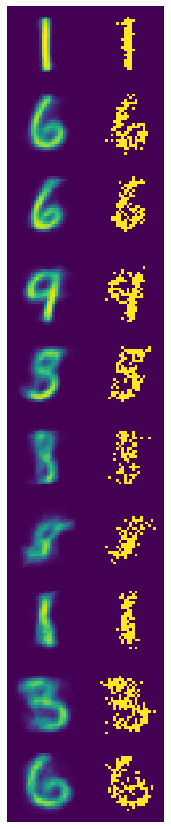

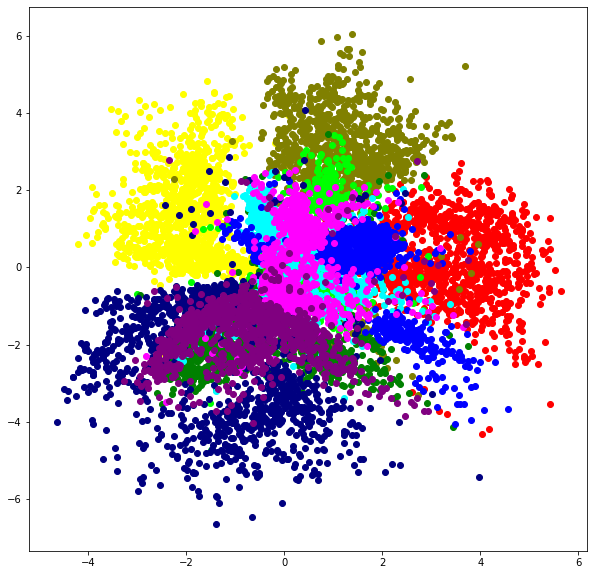

<Figure size 432x288 with 0 Axes>

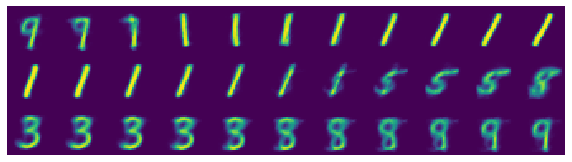

In [31]:
import sys
import argparse
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from hw5_utils import *




# The "encoder" model q(z|x)
class Encoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units
        
        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)

    def forward(self, x):
        # Input: x input image [batch_size x data_dimension]
        # Output: parameters of a diagonal gaussian 
        #   mean : [batch_size x latent_dimension]
        #   variance : [batch_size x latent_dimension]

        hidden = torch.tanh(self.fc1(x))
        mu = self.fc2_mu(hidden)
        log_sigma_square = self.fc2_sigma(hidden)
        sigma_square = torch.exp(log_sigma_square)  
        return mu, sigma_square


# "decoder" Model p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Decoder, self).__init__()
        # Input:
        #   latent_dimension: the latent dimension of the encoder
        #   hidden_units: the number of hidden units

        # TODO: deine the parameters of the decoder
        # fc1: a fully connected layer with 500 hidden units. 
        # fc2: a fully connected layer with 500 hidden units. 
        self.fc1 = nn.Linear(latent_dimension, 500) 
        self.fc2 = nn.Linear(500, data_dimension)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    def forward(self, z):
        # input
        #   z: latent codes sampled from the encoder [batch_size x latent_dimension]
        # output 
        #   p: a tensor of the same size as the image indicating the probability of every pixel being 1 [batch_size x data_dimension]

        # TODO: implement the decoder here. The decoder is a multi-layer perceptron with two hidden layers. 
        # The first layer is followed by a tanh non-linearity and the second layer by a sigmoid.
        hidden = self.tanh(self.fc1(z))
        p = self.sigmoid(self.fc2(hidden))
        return p


# VAE model
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.latent_dimension = args.latent_dimension
        self.hidden_units =  args.hidden_units
        self.data_dimension = args.data_dimension
        self.resume_training = args.resume_training
        self.batch_size = args.batch_size
        self.num_epoches = args.num_epoches
        self.e_path = args.e_path
        self.d_path = args.d_path

        # load and pre-process the data
        N_data, self.train_images, self.train_labels, test_images, test_labels = load_mnist()

        # Instantiate the encoder and decoder models 
        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    # Sample from Diagonal Gaussian z~N(μ,σ^2 I) 
    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        # Inputs:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   sample: from a diagonal gaussian with mean mu and variance sigma_square [batch_size x latent_dimension]

        # TODO: Implement the reparameterization trick and return the sample z [batch_size x latent_dimension]
        sample = mu + torch.sqrt(sigma_square) * torch.randn(sigma_square.shape)
        return sample

    # Sampler from Bernoulli
    @staticmethod
    def sample_Bernoulli(p):
        # Input: 
        #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
        # Output:
        #   x: pixels'labels [batch_size x data_dimension]

        # TODO: Implement a sampler from a Bernoulli distribution
        # x = torch.rand(p.shape[1])
        # x = (x>p).float()   
        x = torch.rand(p.shape)
        x = (x<p).float()        
        return x


    # Compute Log-pdf of z under Diagonal Gaussian N(z|μ,σ^2 I)
    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        # Input:
        #   z: sample [batch_size x latent_dimension]
        #   mu: mean of the gaussian distribution [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]
        # Output:
        #    logprob: log-probability of a diagomnal gaussian [batch_size]
        
        # TODO: implement the logpdf of a gaussian with mean mu and variance sigma_square*I
#         log_sigma = torch.sum(torch.log(sigma_square), 1)
#         z_mu = z - mu
#         sigma_inverse = 1/sigma_square
#         k = z.shape[1]
        
#         logprob = -0.5 * (log_sigma + (z_mu.T @ sigma_inverse @ z_mu) - k/2 * np.log(np.pi *2))
#         # logprob = -0.5 * ((z - mu)/sigma_square)**2 - np.log(torch.sqrt(np.pi * 2) * torch.sqrt(sigma_square))
#         return logprob
          log_det_sigma = torch.sum(torch.log(sigma_square),-1) # batch_size
          #since the variance is diagonal, determinant is the product of elements on the diagonal
          z_mu_diff = z-mu # batch_size x dimension
          sigma_inverse = 1/sigma_square # batch_size x dimension
          k = z.shape[-1]
          s = z_mu_diff.shape[-1]
          logprob = -0.5*(log_det_sigma + torch.bmm(z_mu_diff.view(-1,1,s), (sigma_inverse * z_mu_diff).view(-1,s,1)).view(-1) + k * np.log(np.pi*2))
          return logprob

        # logprob = -0.5 * (log_sigma + torch.dot(z_mu, sigma_inverse * z_mu) - k * np.log(np.pi *2))
    # Compute log-pdf of x under Bernoulli 
    @staticmethod
    def logpdf_bernoulli(x, p):
        # Input:
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        # Output:
        #   logprob: log-probability of a diagonal gaussian [batch_size]

        # TODO: implement the log likelihood of a bernoulli distribution p(x)
        logprob = torch.sum(x*torch.log(p) + (1-x)*torch.log(1-p),-1)
        return logprob
    
    # Sample z ~ q(z|x)
    def sample_z(self, mu, sigma_square):
        # input:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   zs: samples from q(z|x) [batch_size x latent_dimension] 
        zs = VAE.sample_diagonal_gaussian(mu, sigma_square)
        return zs 


    # Variational Objective
    def elbo_loss(self, sampled_z, mu, sigma_square, x, p):
        # Inputs
        #   sampled_z: samples z from the encoder [batch_size x latent_dimension]
        #   mu:
        #   sigma_square: parameters of q(z|x) [batch_size x 1]
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of a pixel being labeled 1 [batch_size x data_dimension]
        # Output
        #   elbo: the ELBO loss (scalar)

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q = self.logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)
        
        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = self.logpdf_bernoulli(x, p)
        
        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo = torch.mean(log_p + log_p_z - log_q)
        return elbo


    def train(self):
        
        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params)

        # Train for ~200 epochs 
        num_batches = int(np.ceil(len(self.train_images) / self.batch_size))
        num_iters = self.num_epoches * num_batches
        
        for i in range(num_iters):
            x_minibatch = self.train_images[batch_indices(i, num_batches, self.batch_size),:]
            adam_optimizer.zero_grad()

            mu, sigma_square = self.encoder(x_minibatch)
            zs = self.sample_z(mu, sigma_square)
            p = self.decoder(zs)
            elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
            total_loss = -elbo
            total_loss.backward()
            adam_optimizer.step()

            if i%100 == 0:
                print("Epoch: " + str(i//num_batches) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))

        # Save Optimized Model Parameters
        torch.save(self.encoder.state_dict(), self.e_path)
        torch.save(self.decoder.state_dict(), self.d_path)


    # Generate digits using the VAE
    def visualize_data_space(self):
        # TODO: Sample 10 z from prior 
        mu_z = torch.tensor([0]*self.latent_dimension).expand(10,-1).float()
        sigma_z = torch.tensor([1]*self.latent_dimension).expand(10,-1).float()
        sample_z = VAE.sample_diagonal_gaussian(mu_z, sigma_z)
        
        # TODO: For each z, plot p(x|z)
        plot = []
        # decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        p_x_z = self.decoder(sample_z) #dimemsion: 10 * data_dimension  #this works because self.decoder = Decoder(three arguments) 
        # and when I do self.decoder(input), it automaticall calls forward
        for i in range(10):
            plot.append(array_to_image(p_x_z[i,:].detach().numpy())) #we don't include this part in GD 
        
        # TODO: Sample x from p(x|z) 
        sample_x = self.sample_Bernoulli(p_x_z)
        xs = []
        for i in range(10):
            xs.append(array_to_image(sample_x[i,:].detach().numpy()))


        # TODO: Concatenate plots into a figure (use the function concat_images)
        concated_image = concat_images(plot+xs, 10, 2)
        fig = plt.figure(figsize = (15,15))
        plt.axis('off')
        plt.imshow(concated_image)
        plt.savefig("visualize_data_space.pdf")
        # TODO: Save the generated figure and include it in your report
        
        
    # Produce a scatter plot in the latent space, where each point in the plot will be the mean vector 
    # for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot 
    # by the class label for the input data. Each point in the plot is colored by the class label for 
    # the input data.
    # The latent space should have learned to distinguish between elements from different classes, even though 
    # we never provided class labels to the model!
    def visualize_latent_space(self):
        
        # TODO: Encode the training data self.train_images
        mu, sigma_square = self.encoder(self.train_images)

        # TODO: Take the mean vector of each encoding
        mean = mu.detach().numpy()

        # TODO: Plot these mean vectors in the latent space with a scatter
        # Colour each point depending on the class label 
        colours = ["Red", "Yellow", "Olive", "Lime", "Green", 
                   "Aqua","Blue","Navy", "Fuchsia", "Purple"]
        fig = plt.figure(figsize = (10,10))
        for i in range(10): 
            sample_index = np.nonzero(self.train_labels.numpy()[:,i])[0]
            cur_digit_means = mean[sample_index]
            plt.scatter(cur_digit_means[:,0], cur_digit_means[:,1],c=colours[i])
        plt.show()
        plt.savefig("visualize_latent_space.pdf")

        # TODO: Save the generated figure and include it in your report
        


    # Function which gives linear interpolation z_α between za and zb
    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.5):
        return alpha*mua + (1-alpha)*mub


    # A common technique to assess latent representations is to interpolate between two points.
    # Here we will encode 3 pairs of data points with different classes.
    # Then we will linearly interpolate between the mean vectors of their encodings. 
    # We will plot the generative distributions along the linear interpolation.
    def visualize_inter_class_interpolation(self):
        
        # TODO: Sample 3 pairs of data with different classes
        pairs = []
        while len(pairs) < 3:
            i1 = int(np.random.rand() * 10000)
            i2 = int(np.random.rand() * 10000)
            if not self.train_labels[i1].equal(self.train_labels[i2]):
                pairs.append([self.train_images[i1],self.train_images[i2]])        

        # Encode the data in each pair, and take the mean vectors
        pairs_mus = []
        for p in pairs:
            mu1, sigma_square1 = self.encoder(p[0])
            mu2, sigma_square2 = self.encoder(p[1])
            pairs_mus.append([mu1,mu2])

        # Linearly interpolate between these mean vectors
        z_alphas = []
        for alpha in np.arange(0,1.1,0.1):
            for p in pairs_mus:
                z_alphas.append(VAE.interpolate_mu(p[0],p[1],alpha))

        # Along the interpolation, plot the distributions p(x|z_α)
        plots = []
        for z in z_alphas:
            y = self.decoder(z)
            plots.append(array_to_image(y.detach().numpy()))

        # Concatenate these plots into one figure
        final_plot = concat_images(plots, 3,11)
        fig = plt.figure(figsize = (10,10))
        plt.axis('off')
        plt.imshow(final_plot)
        plt.savefig("visualize_inter_class_interpolation.pdf")

def parse_args():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--e_path', type=str, default="./e_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="./d_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=500, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default='2', help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default='784', help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--num_epoches', type=int, default=200, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=100, help='Batch size.')

#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    return args


def main():
    
    # read the function arguments
    args = parse_args()

    # set the random seed 
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
    
    # train the model 
    vae = VAE(args)
    vae.train()

    # visualize the latent space
    vae.visualize_data_space()
    vae.visualize_latent_space()
    vae.visualize_inter_class_interpolation()
main()


In [ ]:
# 